In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from rl_analysis.plotting import savefig, setup_plotting_env, clean_ticks
from rl_analysis.io.df import dlight_exclude_toml
from rl_analysis.photometry.signal import get_ncrossings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Helper functions

## load in new dlight data and preprocess

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [4]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
dlight_cfg = analysis_config["dlight_basic_analysis"]
dlight_common_cfg = analysis_config["dlight_common"]
figure_cfg = analysis_config["figures"]

In [5]:
use_dct = dlight_exclude_toml(
    os.path.join(raw_dirs["dlight"], "dlight_photometry_processed_full.toml"),
    **analysis_config["dlight_common"]
)

In [6]:
dlight_df = pd.read_parquet(
    os.path.join(raw_dirs["dlight"], "dlight_photometry_processed_full.parquet"),
    filters=[("uuid", "in", list(use_dct.keys())), ("area", "=", "dls")],
).sort_index()

In [7]:
dlight_df["uuid"] = dlight_df["uuid"].astype("str")
dlight_df["mouse_id"] = dlight_df["mouse_id"].astype("str")

In [8]:
dlight_df = dlight_df.loc[~dlight_df["session_number"].isin([1, 2, 3, 4])].copy()

In [9]:
signal_keys = dlight_df.filter(regex="(signal|reference|reref)_dff$").columns.tolist()

In [10]:
dlight_df["labels"] = (
    dlight_df["predicted_syllable (offline)"].replace(-5, np.nan).astype("UInt8")
)
dlight_df = dlight_df.dropna(subset=["labels"])

In [11]:
def mark_threshold_crossing(values, threshold=1.96):
    locs = np.zeros((len(values),), dtype="bool")
    locs[1:] = (values.to_numpy()[:-1] <= threshold) & (
        values.to_numpy()[1:] > threshold
    )
    return pd.Series(data=locs, index=values.index)

In [12]:
dlight_df = dlight_df.dropna(subset=["signal_reref_dff_z"])

In [13]:
_tmp_pos = dlight_df.groupby("uuid", group_keys=False)["signal_reref_dff_z"].apply(
    lambda x: mark_threshold_crossing(+x, threshold=1.0)
)

In [14]:
_tmp = _tmp_pos

In [15]:
time_bin = pd.cut(dlight_df["timestamp"], np.arange(0, 1800, 60))

In [16]:
time_bin_szs = dlight_df.groupby(time_bin).size()

In [17]:
cutoff = time_bin_szs.quantile(0.05)

In [18]:
include_bins = time_bin_szs.loc[time_bin_szs > cutoff].index

In [19]:
period = 1 / 30.0

In [20]:
peaks_over_time = _tmp_pos.groupby([dlight_df["mouse_id"], time_bin]).mean()
peaks_over_time /= period

In [21]:
peaks_over_time = peaks_over_time.loc[
    peaks_over_time.index.get_level_values("timestamp").isin(include_bins)
]

In [22]:
peaks_over_time = peaks_over_time.reset_index()

In [23]:
peaks_over_time["timestamp"] = (
    peaks_over_time["timestamp"].apply(lambda x: x.mid).astype("float")
)
peaks_over_time["timestamp"] /= 60.0

In [24]:
setup_plotting_env()

In [25]:
ref = peaks_over_time.groupby("timestamp").mean().iloc[0]
show_peaks = peaks_over_time.copy()
show_peaks["signal_reref_dff_z"] = (
    1e2 * ((peaks_over_time - ref) / ref)["signal_reref_dff_z"]
)

/tmp/ipykernel_1439794/3708941910.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ref = peaks_over_time.groupby("timestamp").mean().iloc[0]


In [26]:
peaks_over_time

,mouse_id,timestamp,signal_reref_dff_z
0,dlight-chrimson-1,0.5,1.249047
1,dlight-chrimson-1,1.5,1.225143
2,dlight-chrimson-1,2.5,1.196476
3,dlight-chrimson-1,3.5,1.208333
4,dlight-chrimson-1,4.5,1.191529
...,...,...,...
373,dls-dlight-7,22.5,1.317949
374,dls-dlight-7,23.5,1.329487
375,dls-dlight-7,24.5,1.389744
376,dls-dlight-7,25.5,1.407692


In [27]:
threshold = 1
schmitt = 3
schmitt_threshold = 0.25 * threshold
period = 1.0 / 30.0

In [28]:
dlight_df["time_bin"] = pd.cut(dlight_df["timestamp"], np.arange(0, 1800, 60))

In [29]:
_tmp_rate = (
    dlight_df.set_index("timestamp")
    .groupby(["area", "mouse_id", "uuid", "time_bin"])["signal_reref_dff_z"]
    .agg(
        lambda x: get_ncrossings(
            x, threshold=threshold, schmitt=schmitt, schmitt_threshold=schmitt_threshold
        )
    )
    .rename("transient_rate")
)

In [30]:
_tmp_amplitude = (
    dlight_df.groupby(["area", "mouse_id", "uuid", "time_bin"])["signal_dff"]
    .apply(lambda x: x.max() * 1e2)
    .rename("peak_dff")
    .dropna()
)

In [31]:
time_df = pd.concat([_tmp_rate, _tmp_amplitude], axis=1).reset_index()

In [32]:
time_df = time_df.loc[time_df["time_bin"].isin(include_bins)]

In [33]:
time_df["time_bin"] = time_df["time_bin"].apply(lambda x: x.mid).astype("float")
time_df["time_bin"] /= 60.0

In [34]:
to_plot = time_df.groupby(["mouse_id", "uuid", "time_bin"]).mean()
ref = to_plot.groupby(["mouse_id", "uuid"]).head(2).mean()

/tmp/ipykernel_1439794/3407605366.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  to_plot = time_df.groupby(["mouse_id", "uuid", "time_bin"]).mean()


In [35]:
to_plot_rel = 1e2 * (to_plot - ref) / ref

In [36]:
sns.set_context("paper")

In [37]:
to_plot_rel = to_plot_rel.groupby(["mouse_id", "time_bin"]).mean()
to_plot = to_plot.groupby(["mouse_id", "time_bin"]).mean()

In [38]:
setup_plotting_env()

/tmp/ipykernel_1439794/2477773179.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=to_plot_rel, x="time_bin", y="transient_rate", ci=95, ax=ax[0])
/tmp/ipykernel_1439794/2477773179.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=to_plot, x="time_bin", y="peak_dff", ci=95, ax=ax[1])


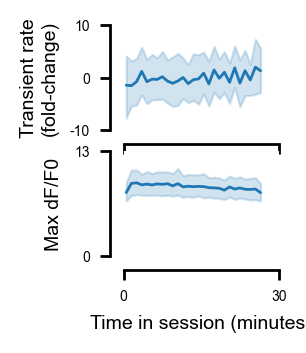

In [39]:
fig, ax = plt.subplots(2, 1, figsize=(1, 1.5), sharex=True, sharey=False)
sns.lineplot(data=to_plot_rel, x="time_bin", y="transient_rate", ci=95, ax=ax[0])
sns.lineplot(data=to_plot, x="time_bin", y="peak_dff", ci=95, ax=ax[1])
plt.xlim(0, 30)
# plt.axhline(y=0, zorder=-300, color=plt.rcParams["axes.edgecolor"])
clean_ticks(ax, "x", zero_symmetry=False, precision=0, dtype=int)
clean_ticks(ax[0], "y", zero_symmetry=True, precision=-1, dtype=int)
ax[0].set_ylabel("Transient rate\n(fold-change)")
ax[1].set_ylim(0, 13)
ax[1].set_ylabel("Max dF/F0")
clean_ticks(ax[1], "y", zero_symmetry=False, precision=0, dtype=int)
plt.xlabel("Time in session (minutes)")
sns.despine(offset=5)
# plt.ylabel("Probability of DA transient (percent change)")
savefig(fig, os.path.join(figure_cfg["store_dir"], "da_peaks_over_time_percent"))